- from dataset, readme 
- 연습 내용 중 하나 제안만 선택해 분석
- 결측치나 이상치는 분석가 판단해 처리
- 공통 주제 제안 4

1. 동일한 시기에 동일한 차종(product)을 선택했다고 했을 때, 
2. 사람들이 금액을 얼만큼(amount)을 사용했는지 최대와 미니멈, 그리고 평균을 확인 할 수 있게, 
3. 또한 차종별 가장 많은 돈을 쓴 비율에 많은 세대와 반대로 적은 돈을 쓴 세대는 어디인지? 확인하기
4. 특정한 세대를 통해 다른 데이터들의 상관관계 분석후 +1에 가까운 컬럼을 통해 전략 세우기 

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl # 한글 폰트 설정 (NanumGothic)

plt.rc('font', family='NanumGothic')  # 나눔고딕 폰트 사용
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
rentAcar = pd.read_csv('../../datasets/LetalCarOfContractType.csv')
rentAcar.head()

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage
0,66758234,렌탈,Normal,서비스 방문,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,9.0,새마을금고,정상,43.0,1862.0
1,66755948,렌탈,Extension_Rental,서비스 방문,2019-10-20,60,카드이체,K1,102900,계약확정,0,없음,2.0,현대카드,정상,62.0,2532.0
2,66756657,렌탈,Normal,홈쇼핑/방송,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,8.0,우리은행,정상,60.0,2363.0
3,66423450,멤버십,TAS,렌탈재계약,2019-10-20,12,CMS,K1,66900,계약확정,0,없음,5.0,농협은행,정상,60.0,2449.0
4,66423204,멤버십,TAS,렌탈재계약,2019-10-20,12,CMS,K1,66900,해약확정,12,있음,8.0,농협은행,해약,51.0,1942.0


In [41]:
# datetime 컬럼 변환
rentAcar['datetime'] = pd.to_datetime(rentAcar['datetime'])

# 연령대 함수 수정 (Unknown 포함)
def get_age_group(age):
    if pd.isna(age):
        return 'Unknown'
    return f"{(age//10)*10}"

# 연령대 컬럼 추가
rentAcar['age'] = rentAcar['age'].apply(get_age_group)

# 날짜별, 차종별, 연령대별 그룹화하여 통계 계산
grouped_stats = rentAcar.groupby(['datetime', 'product', 'age'])['amount'].agg([
    'min',
    'max',
    'mean',
    'count'
]).reset_index()

/tmp/ipykernel_521/2158670619.py:44: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


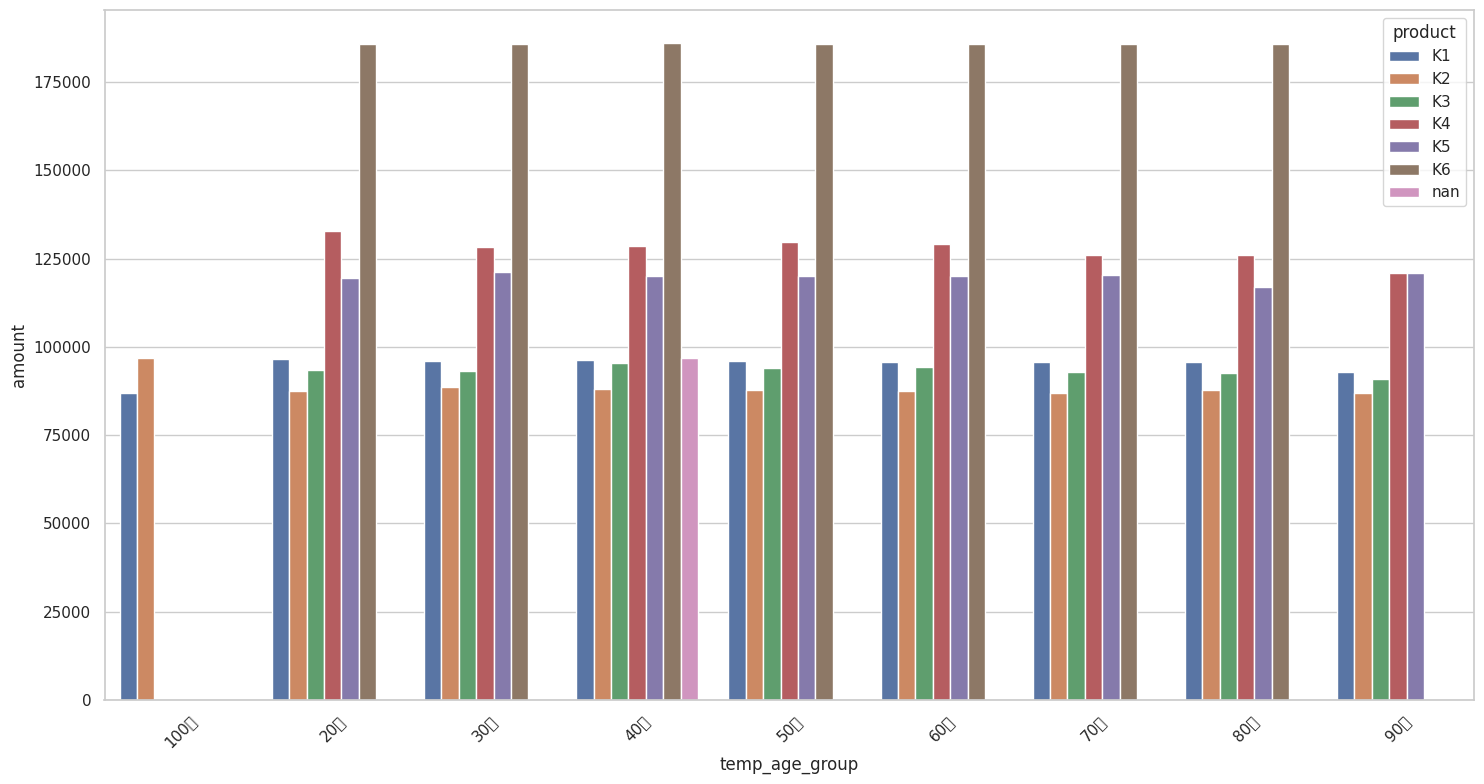

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 3. seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 4. 연령대 함수 수정
def get_age_group(age):
    if pd.isna(age) or age == 'Unknown':
        return 'Unknown'
    age = int(float(age))
    return f"{(age//10)*10}대"

# 5. 데이터 처리
rentAcar['product'] = rentAcar['product'].astype(str)
rentAcar['temp_age_group'] = rentAcar['age'].apply(get_age_group)
rentAcar['month'] = pd.to_datetime(rentAcar['datetime']).dt.to_period('M')

# 6. 월별, 차종별, 연령대별 평균 지출액 계산 (Unknown 제외)
monthly_stats = (rentAcar[rentAcar['temp_age_group'] != 'Unknown']
                .groupby(['month', 'product', 'temp_age_group'])['amount']
                .mean()
                .reset_index())

# 7. 그래프 설정
plt.figure(figsize=(15, 8))

# 8. 차종별로 색상 구분하여 막대 그래프 그리기
sns.barplot(data=monthly_stats, x='temp_age_group', y='amount', hue='product', errorbar=None)

# # 9. 그래프 제목 및 레이블 설정
# plt.title('월별 차종 및 연령대 평균 지출액', fontproperties=font_prop)
# plt.xlabel('연령대', fontproperties=font_prop)
# plt.ylabel('평균 지출액 (원)', fontproperties=font_prop)
# plt.legend(title='차종', bbox_to_anchor=(1.05, 1), loc='upper left', prop=font_prop)

# 10. x축 레이블 회전
plt.xticks(rotation=45)

# 11. 그래프 보여주기
plt.tight_layout()
plt.show()

# 12. 임시 컬럼 제거
rentAcar.drop(['temp_age_group', 'month'], axis=1, inplace=True)


/tmp/ipykernel_521/3556058801.py:53: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/3556058801.py:53: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/3556058801.py:53: UserWarning: Glyph 47161 (\N{HANGUL SYLLABLE RYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/3556058801.py:53: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/3556058801.py:53: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/3556058801.py:53: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/3556058801.py:53: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_

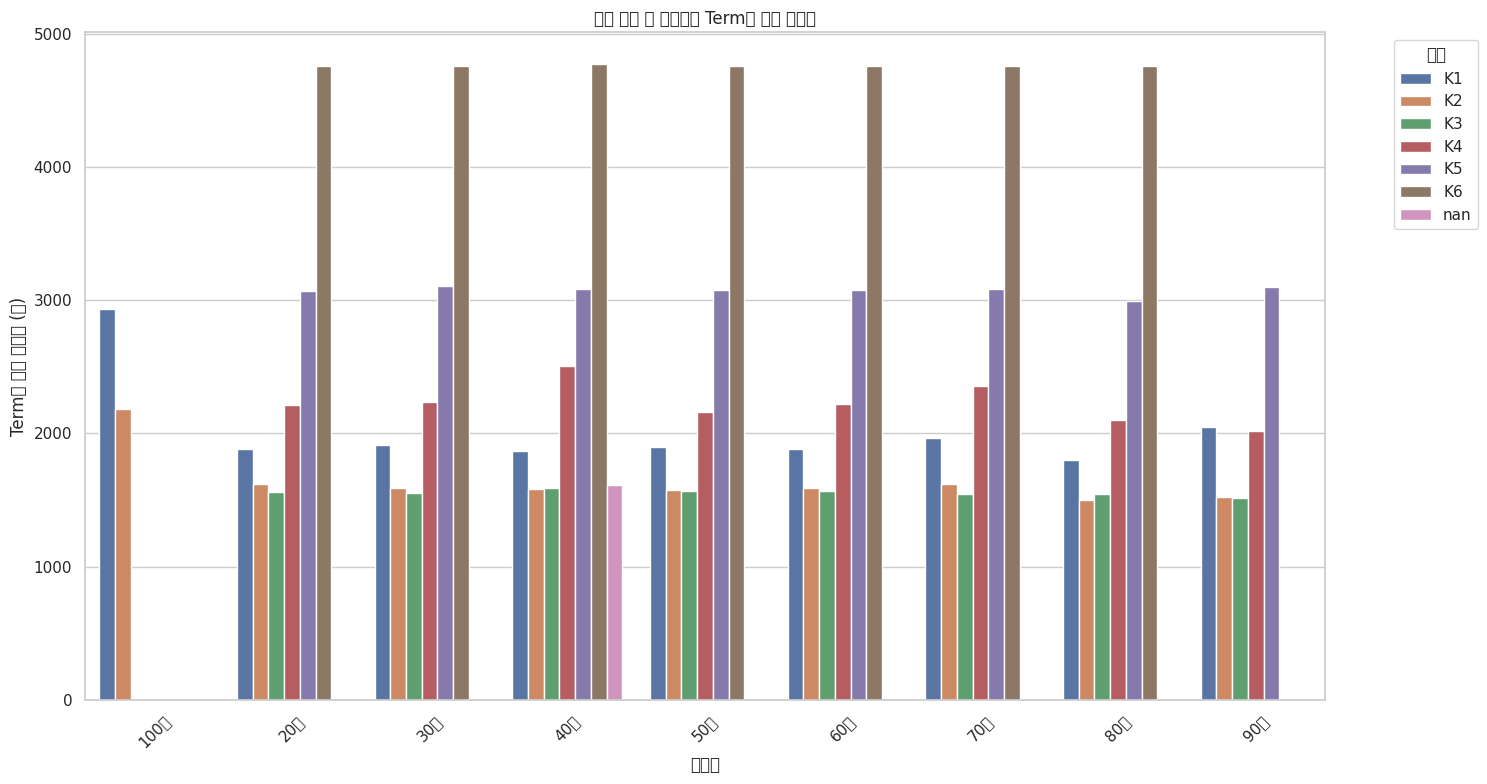


차종별 Term당 금액 통계:
        amount_per_term                         
                   mean      min      max  count
product                                         
K1              1910.73  1365.00  8575.00  39134
K2              1613.58  1215.00  5575.00   8995
K3              1596.10  1515.00  3525.00   2082
K4              2265.73  2015.00  6325.00    327
K5              3070.42  2792.31  3253.85    645
K6              4857.69  4761.54  5530.77    120
nan             1615.00  1615.00  1615.00      1

연령대별 Term당 금액 통계:
               amount_per_term                       
                          mean     min     max  count
temp_age_group                                       
100대                   2465.56  1515.0  5575.0      6
20대                    1826.26  1315.0  8050.0   4239
30대                    1846.31  1315.0  8050.0   8838
40대                    1842.61  1215.0  8575.0  11099
50대                    1852.79  1215.0  8050.0   9218
60대                    1865.21  1315.0  8

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 1. Term당 amount 계산 함수
def calculate_amount_per_term(df):
    # Term이 0인 경우를 방지하기 위해 1로 대체 (또는 다른 처리 방법 선택 가능)
    df['Term'] = df['Term'].replace(0, 1)
    # Term당 amount 계산
    df['amount_per_term'] = df['amount'] / df['Term']
    return df

# 2. 연령대 함수 수정
def get_age_group(age):
    if pd.isna(age) or age == 'Unknown':
        return 'Unknown'
    age = int(float(age))
    return f"{(age//10)*10}대"

# 3. seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 4. 데이터 처리
rentAcar['product'] = rentAcar['product'].astype(str)
rentAcar = calculate_amount_per_term(rentAcar)  # Term당 amount 계산
rentAcar['temp_age_group'] = rentAcar['age'].apply(get_age_group)
rentAcar['month'] = pd.to_datetime(rentAcar['datetime']).dt.to_period('M')

# 5. 월별, 차종별, 연령대별 Term당 평균 지출액 계산 (Unknown 제외)
monthly_stats = (rentAcar[rentAcar['temp_age_group'] != 'Unknown']
                .groupby(['month', 'product', 'temp_age_group'])['amount_per_term']  # amount 대신 amount_per_term 사용
                .mean()
                .reset_index())

# 6. 그래프 설정
plt.figure(figsize=(15, 8))

# 7. 차종별로 색상 구분하여 막대 그래프 그리기
sns.barplot(data=monthly_stats, x='temp_age_group', y='amount_per_term', hue='product', errorbar=None)

# 8. 그래프 제목 및 레이블 설정
plt.title('월별 차종 및 연령대별 Term당 평균 지출액')
plt.xlabel('연령대')
plt.ylabel('Term당 평균 지출액 (원)')
plt.legend(title='차종', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. x축 레이블 회전
plt.xticks(rotation=45)

# 10. 그래프 보여주기
plt.tight_layout()
plt.show()

# 11. 차종별 Term당 평균, 최소, 최대 금액 출력
product_stats = rentAcar.groupby('product').agg({
    'amount_per_term': ['mean', 'min', 'max', 'count']
}).round(2)

print("\n차종별 Term당 금액 통계:")
print("=" * 50)
print(product_stats)

# 12. 연령대별 Term당 평균, 최소, 최대 금액 출력
age_stats = rentAcar[rentAcar['temp_age_group'] != 'Unknown'].groupby('temp_age_group').agg({
    'amount_per_term': ['mean', 'min', 'max', 'count']
}).round(2)

print("\n연령대별 Term당 금액 통계:")
print("=" * 50)
print(age_stats)

# 13. 상위/하위 25% 분석
for product in rentAcar['product'].unique():
    product_data = rentAcar[rentAcar['product'] == product]
    
    print(f"\n{product} 차종 분석:")
    print("=" * 50)
    
    # Term당 amount 기준으로 상위/하위 25% 구분
    top_25_mask = product_data['amount_per_term'] >= product_data['amount_per_term'].quantile(0.75)
    bottom_25_mask = product_data['amount_per_term'] <= product_data['amount_per_term'].quantile(0.25)
    
    # 연령대별 분포 계산
    top_25_age_dist = product_data[top_25_mask]['temp_age_group'].value_counts(normalize=True) * 100
    bottom_25_age_dist = product_data[bottom_25_mask]['temp_age_group'].value_counts(normalize=True) * 100
    
    print("\n상위 25% 연령대 분포 (%):")
    print(top_25_age_dist.round(2))
    print("\n하위 25% 연령대 분포 (%):")
    print(bottom_25_age_dist.round(2))


/tmp/ipykernel_521/1969778098.py:97: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/1969778098.py:97: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/1969778098.py:97: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/1969778098.py:97: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/1969778098.py:97: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/1969778098.py:97: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_521/1969778098.py:97: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout

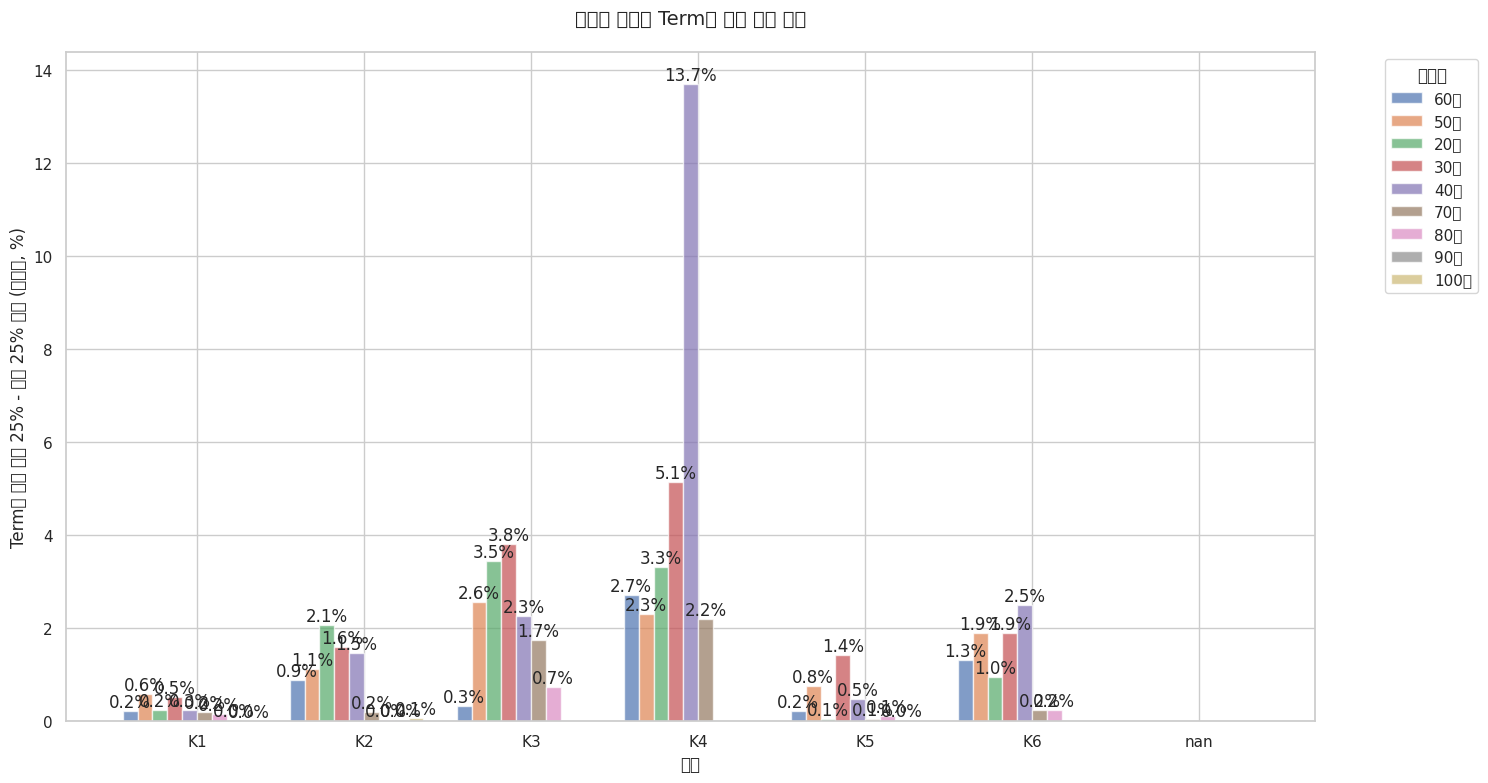


차종별 연령대 Term당 금액 차이 (절댓값, %):
          60대   50대   20대   30대    40대   70대   80대   90대  100대
Dataset                                                       
K1       0.21  0.58  0.25  0.52   0.25  0.21  0.16  0.03  0.00
K2       0.88  1.13  2.06  1.59   1.48  0.20  0.02  0.02  0.06
K3       0.34  2.56  3.45  3.81   2.27  1.74  0.75  0.00  0.00
K4       2.72  2.31  3.31  5.14  13.71  2.19  0.00  0.00  0.00
K5       0.22  0.76  0.05  1.43   0.48  0.06  0.11  0.02  0.00
K6       1.31  1.90  0.95  1.90   2.50  0.24  0.24  0.00  0.00
nan      0.00  0.00  0.00  0.00   0.00  0.00  0.00  0.00  0.00


In [44]:


# 결과를 저장할 빈 데이터프레임 생성
results = []

# 연령대를 계산하는 함수
def get_age_group(age):
    if pd.isna(age):
        return 'Unknown'
    return f"{(age//10)*10}대"

# 각 차종별로 분석
for product in rentAcar['product'].unique():
    if pd.isna(product):  # nan 값 제외
        continue
        
    product_data = rentAcar[rentAcar['product'] == product]
    
    # Term당 amount 기준으로 상위/하위 25% 구분
    q75 = product_data['amount_per_term'].quantile(0.75)
    q25 = product_data['amount_per_term'].quantile(0.25)
    
    top_25 = product_data[product_data['amount_per_term'] >= q75]
    bottom_25 = product_data[product_data['amount_per_term'] <= q25]
    
    # 각 그룹의 연령대별 분포 계산
    for age_group in top_25['temp_age_group'].unique():
        # 상위 25% 분포
        top_ratio = (len(top_25[top_25['temp_age_group'] == age_group]) / len(top_25) * 100)
        results.append({
            'Dataset': product,
            'Age_Group': age_group,
            'Percentage': top_ratio,
            'Group': 'Top 25%'
        })
        
        # 하위 25% 분포
        bottom_ratio = (len(bottom_25[bottom_25['temp_age_group'] == age_group]) / len(bottom_25) * 100)
        results.append({
            'Dataset': product,
            'Age_Group': age_group,
            'Percentage': bottom_ratio,
            'Group': 'Bottom 25%'
        })

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 차이 계산
def calculate_difference():
    pivot_data = results_df.pivot_table(
        index='Dataset', 
        columns=['Age_Group', 'Group'], 
        values='Percentage',
        fill_value=0
    )
    
    # 각 연령대별로 상위 25%와 하위 25% 차이 계산
    diff_dict = {}
    for age_group in results_df['Age_Group'].unique():
        if age_group == 'Unknown':
            continue
        top_col = (age_group, 'Top 25%')
        bottom_col = (age_group, 'Bottom 25%')
        if top_col in pivot_data.columns and bottom_col in pivot_data.columns:
            diff_dict[age_group] = abs(pivot_data[top_col] - pivot_data[bottom_col])
    
    return pd.DataFrame(diff_dict)

# 차이 계산
diff_df = calculate_difference()

# 시각화
plt.figure(figsize=(15, 8))

# 각 데이터셋별로 연령대 차이를 막대 그래프로 표시
x = np.arange(len(diff_df.index))
width = 0.8 / len(diff_df.columns)  # 막대 너비

# 각 연령대별로 막대 그래프 생성
for i, age_group in enumerate(diff_df.columns):
    plt.bar(x + i * width, diff_df[age_group], 
            width, label=age_group, alpha=0.7)

# 그래프 꾸미기
plt.xlabel('차종', fontsize=12)
plt.ylabel('Term당 금액 상위 25% - 하위 25% 차이 (절댓값, %)', fontsize=12)
plt.title('차종별 연령대 Term당 금액 차이 분석', fontsize=14, pad=20)
plt.xticks(x + width * len(diff_df.columns) / 2, diff_df.index)
plt.legend(title='연령대', bbox_to_anchor=(1.05, 1), loc='upper left')

# 값 레이블 표시
for i, age_group in enumerate(diff_df.columns):
    for j, value in enumerate(diff_df[age_group]):
        if value > 0:  # 0보다 큰 값만 표시
            plt.text(j + i * width, value, f'{value:.1f}%', 
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 수치로도 확인
print("\n차종별 연령대 Term당 금액 차이 (절댓값, %):")
print("=" * 50)
print(diff_df.round(2))


**K1**
- 가장 큰 차이: Unknown(11.75%), 40대(4.30%)
- 30대(2.31%)와 50대(1.75%)에서도 비교적 큰 차이
- 80대(0.07%), 90대(0.05%), 100대(0.01%)는 매우 작은 차이

**K2**
- 전반적으로 차이가 작은 편
- 가장 큰 차이: Unknown(4.45%), 20대(1.83%)
- 30대(0.76%), 40대(0.71%), 60대(0.70%) 비슷한 수준
- 90대(0.01%)에서 가장 작은 차이

**K3**
- Unknown(12.07%)이 가장 큰 차이
- 젊은층에서 큰 차이: 30대(3.64%), 20대(3.37%)
- 50대(2.36%), 40대(2.02%)도 상당한 차이
- 100대(0.00%)에서 차이 없음

**K4**
- 중장년층에서 가장 큰 차이: 60대(5.80%), 50대(4.66%)
- 70대(3.88%)도 높은 차이
- Unknown은 4.13%
- 젊은층은 상대적으로 작은 차이: 20대(0.28%), 30대(0.27%)
- 100대(0.00%)에서 차이 없음

**K5**
- 전 연령대에서 가장 작은 차이를 보임
- 최대 차이는 30대(1.43%)
- Unknown(0.02%)도 매우 작음
- 100대(0.00%)에서 차이 없음

**K6**
- Unknown(9.05%)이 가장 큰 차이
- 40대(2.50%)에서 가장 큰 실제 연령대 차이
- 30대와 50대 모두 1.91%로 동일
- 90대와 100대(0.00%)에서 차이 없음